## Part 9: A/B Testing Design & Execution
Notes from this notebook comes from various resources listed at the end of the notebook. This is used to follow the work done in conducting A/B tests programmatically. The dataset contained randomized generated numbers. The goal is to better understand processes of A/B testing.

-------

### Areas of Focus

- A/B Testing
    - Creating randomized data
- Statistical Analysis
- Machine Learning

### Business Problem

How do you experiment new ideas and sustain continuous learning? With experimentation, a team could learn more about their customers by setting different layouts per situation which can a great way to test your machine learning models, new product features, and improve existing functionalities.

Let's say you have a churn model in production that works pretty well. Using this model, we can identify which customers are likely to churn and contact them to have a chance to retain them as customers. We could give an attractive offer like discounts, which will incentivize them to re-purchase if that's the goal.

In this notebook, there are some assumptions listed below:

- The model’s accuracy is 95%. Is it really? You have trained your model based on last month’s data. The next month, there will be new users, new product features, marketing & brand activities, seasonality and so on. Historical accuracy and real accuracy rarely match in this kind of cases. You can’t come up with a conclusion without a test.


- By looking at the previous campaigns’ results, you are assuming a 10% conversion. It doesn’t guarantee that your new action will have 10% conversion due to the factors above. Moreover, since it is a new group, their reaction is partly unpredictable.


- If those customers bring $20 monthly today, that doesn’t mean they will bring the same after your new action.

If we want to validate some of these assumptions, we need to conduct an A/B test.

### What is AB Testing?

A/B testing is just the tech industry’s word for __randomized controlled trials (RCT)__, which the scientific community has established as the best, and perhaps, only way to do unbiased causal inference.

It’s not just the design and setup of an A/B test that determines the quality of the results, but also what you do with the data afterwards. Mishandling the analysis of your A/B data could lead you to miss an important insight about your product

So in short, A/B testing allows you to run experiments that change the behavior of a user’s experience. In a typical experiment you will have one group of users who will see the current, unmodified behavior (control) and another group of users see the modified behavior (variation).

### Programmatic AB Testing Process

When designing an AB test, we need to follow some steps to ensure that the test is going to be statistically significant and unbiased.

1. Define our hypothesis
    - We have to have a hypothesis that we are assuming to be true or false.
    - Our hypothesis is that the test group (offers used) will have more retention
        - Group A -> Offer -> Higher Retention
        - Group B -> No offer -> Lower Retention
        
2. Define our success metric
    - Group retention rate


3. Evaluation


4. Refine & Repeat

### Data

- customer_id: the unique identifier of the customer
- segment: customer’s segment; high-value or low-value
- group: indicates whether the customer is in the test or control group
- purchase_count: # of purchases completed by the customer

### Libraries

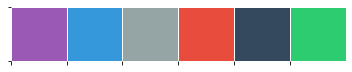

In [1]:
# Toolbox 101
from datetime import datetime, timedelta, date
import pandas as pd
import pandas_profiling
import numpy as np
import random as rand
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import plotly.plotly as py
import plotly.graph_objs as go # graph_objects in version 4 (currently have plotly v3 installed)
import plotly.offline as pyoff
import plotly.figure_factory as ff

# Stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats
import statsmodels.formula.api as smf 
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import power

# Models
from sklearn.cluster import KMeans
from xgboost import XGBRegressor, XGBClassifier, plot_importance, plot_tree

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 5000
pd.options.display.max_rows = 5000

# Set palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
#34495e

seed = 100

### Helpers

In [2]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    if len(all_nulls) > 8:
        plt.figure(figsize=(12, 8))
    elif len(all_nulls) > 5:
        plt.figure(figsize=(6, 8))
    else:
        plt.figure(figsize=(4, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.ylim(0, 100)
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()
    
# Create a new function to capture feature importance for models
def feature_importance(model):
    
    importance = pd.DataFrame({'Feature': headers,
                               'Importance': np.round(model.feature_importances_,3)})
    
    importance = importance.sort_values(by = 'Importance', ascending = False).set_index('Feature')
    
    return importance

# Order clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    '''Add new score to the data'''
    
    # Create a new field name
    new_cluster_field_name = 'new_' + cluster_field_name
    # Group up the recency scores
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    # Merge the dataframes
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={'index': cluster_field_name})
    return df_final

# Define uplift formula
def calc_uplift(data):
    # Assign $25 to the average order value
    avg_order_val = 25
    
    # Calculate conversion for each offer type
    base_conv = data[data.offer=='No Offer']['conversion'].mean()
    disc_conv = data[data.offer=='Discount']['conversion'].mean()
    bogo_conv = data[data.offer=='Buy One Get One']['conversion'].mean()
    
    # Calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    # Calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(data[data.offer=='Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(data[data.offer=='Buy One Get One']['conversion'])
    
    # Calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_val
    bogo_rev_uplift = bogo_order_uplift * avg_order_val
    
    # Print results
    print('-------------- \n')
    print('Uplifts Compared to Control')
    print('-------------- \n')
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100, 2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift, 2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift, 2)))
    print('-------------- \n')
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100, 2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift, 2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift, 2)))
    

### Data

In [4]:
# Create an empty dataframe
data = pd.DataFrame()

# Generate an array of data for each feature
data['customer_id'] = np.array([i for i in range(20000)])
data['segment'] = np.array(['high-value' for _ in range(20000)]) # I don't think I need to loop here
data['group'] = 'control'
data.loc[data.index<10000, 'group'] = 'test'

In [5]:
data.head()

,customer_id,segment,group
0,0,high-value,test
1,1,high-value,test
2,2,high-value,test
3,3,high-value,test
4,4,high-value,test


In [6]:
data.shape

(20000, 3)

Frequency of group :


,Count,Percentage
test,10000,50.0
control,10000,50.0


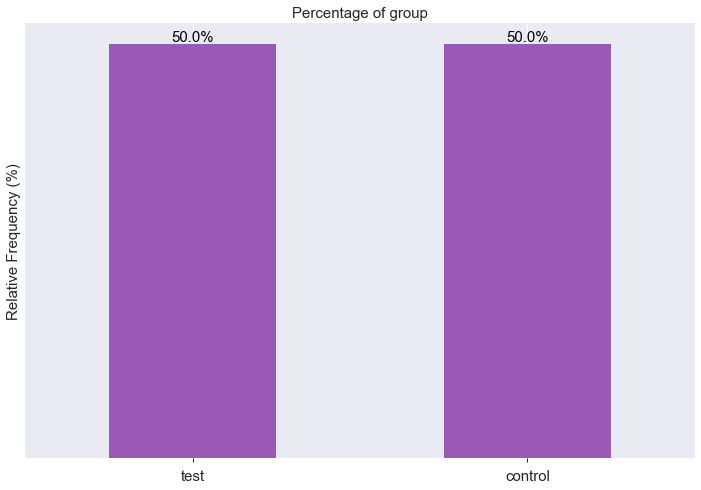

In [8]:
freq_table(data.group)

### Poisson distribution

Purchase count should be a Poisson distribution. Poisson, is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space. For example, the number of times someone walks through a door within a day.

There will be customers with no purchase and we will have less customers with high purchase counts, which is normal. Using numpy, create a new distribution and assign different distributions to test and control groups.

### Create a new purchase_count feature

In [9]:
# Split purchase distribution per group type
data.loc[data.group=='test', 'purchase_count'] = np.random.poisson(0.6, 10000)
data.loc[data.group=='control', 'purchase_count'] = np.random.poisson(0.5, 10000)

In [11]:
data.head()

,customer_id,segment,group,purchase_count
0,0,high-value,test,2.0
1,1,high-value,test,1.0
2,2,high-value,test,1.0
3,3,high-value,test,0.0
4,4,high-value,test,1.0


In [27]:
data.purchase_count.nunique()

6

In [52]:
purchase_data = data.groupby(['group','purchase_count'])[['purchase_count']].count()
purchase_data

purchase_count
group   purchase_count                
control 0.0                       6101
        1.0                       2978
        2.0                        776
        3.0                        129
        4.0                         14
        5.0                          2
test    0.0                       5516
        1.0                       3267
        2.0                        974
        3.0                        212
        4.0                         27
        5.0                          4

In [57]:
purchase_data = data.groupby(['purchase_count'])[['purchase_count']].count()
purchase_data

,purchase_count
purchase_count,
0.0,11617
1.0,6245
2.0,1750
3.0,341
4.0,41
5.0,6


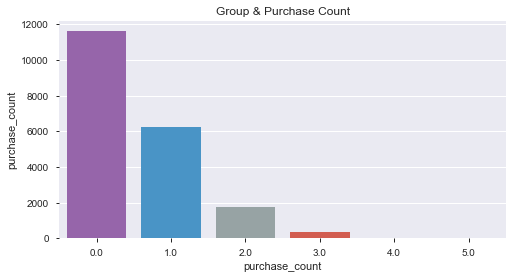

In [58]:
# Set figure space
plt.figure(figsize=(8, 4))

# Create bar plot
sns.barplot(x=purchase_data.index,
            y=purchase_data.purchase_count
           )

# Set plot features
plt.title('Group & Purchase Count')
plt.show()

### Distribution Plot

In [69]:
# Create data by group
test_results = data[data.group=='test'].purchase_count
control_results = data[data.group=='control'].purchase_count

# Combine
hist_data = [test_results, control_results] # stack data
group_labels = ['test', 'control']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data,
                         group_labels,
                         bin_size=.5,
                         curve_type='normal',
                         show_rug=False)

# Plot layout
fig.layout = go.Layout(
        title='High Value Customers Test vs Control',
        plot_bgcolor='rgb(243,243,243)',
        paper_bgcolor ='rgb(243,243,243)',
    )

# Plot
pyoff.iplot(fig)

The distribution of this generated data looks good. As expected, we would see distinct customers have lower amount of purchases and slowly drops as the number of purchases increase.

We also have to test the group's purchase experiment using statistical methods.

### T-Test

In [59]:
test_result = stats.ttest_ind(test_results, control_results)
print(test_result)

Ttest_indResult(statistic=9.469309304882646, pvalue=3.120873937836125e-21)


The test returned an extremely low p-value (measures the probability of the null hypothesis to be true), which is what we want to see. Since the p-value is less than the alpha threshold of 0.05, we can reject the null hypothesis.

#### Some background info
If null hypothesis is true, it means there is no significant difference between your test and control group. So the lower p-value means the better. As the industry standard, we accept that p-value<5% makes the result statistically significant.

### Define a function that will test for us

In [62]:
# Define t-test function and evaluate
def eval_test(test_results,control_results):
    # Type of test
    test_result = stats.ttest_ind(test_results, control_results)
    
    # Return result: reject or do not reject
    if test_result[1] < 0.05:
        print('Result is significant with a p-value of:', test_result[1])
    else:
        print('Result is not significant with a p-value of:', test_result[1])

#### Beware! 
If you select a biased test group (which can often happen when the test is not setup correctly), your results will be statistically significant by default. As an example, if we allocate more high-value customer to test group and more low-value customers to control group, then our experiment becomes a failure from the beginning. That’s why selecting the group is the key to a healthy A/B test.

In [63]:
eval_test(test_results, control_results)

Result is significant with a p-value of: 3.120873937836125e-21


### How to select test & control groups?

The most common approach to select test & control groups is random sampling.

- Create the dataset
- Assign 20k high-value customers and 80k low-value customers
- Sample() to select test group (random)

In [65]:
# Create high-value data
data_hv = pd.DataFrame()
data_hv['customer_id'] = np.array([count for count in range(20000)])
data_hv['segment'] = np.array(['high-value' for _ in range(20000)])
data_hv['prev_purchase_count'] = np.random.poisson(0.9, 20000)

# Create low-value data
data_lv = pd.DataFrame()
data_lv['customer_id'] = np.array([count for count in range(20000,100000)])
data_lv['segment'] = np.array(['low-value' for _ in range(80000)])
data_lv['prev_purchase_count'] = np.random.poisson(0.3, 80000)

# Combine
full_data = pd.concat([data_hv, data_lv],axis=0)

### Sample (split the data) into 90% test and 10% control group

In [67]:
# Split
data_test = full_data.sample(frac=0.9, random_state=100)

# Select control
data_control = full_data[~full_data.customer_id.isin(data_test.customer_id)]

In this example, we extracted 90% of the whole group and labeled it as test. But there is a small problem that can ruin our experiment. If you have significantly different multiple groups in your dataset (in this case, high-value & low-value), better to do random sampling separately. Otherwise, we can’t guarantee that the ratio of high-value to low-value is the same for test and control group.

### Ensure test and control groups are sampled correctly

In [70]:
# Split
data_test_hv = full_data[full_data.segment == 'high-value'].sample(frac=0.9, random_state=100)
data_test_lv = full_data[full_data.segment == 'low-value'].sample(frac=0.9, random_state=100)

# Combine
df_test = pd.concat([data_test_hv, data_test_lv], axis=0)
data_control = full_data[~full_data.customer_id.isin(data_test.customer_id)]

In [71]:
# Check
data_test.segment.value_counts()

low-value     72034
high-value    17966
Name: segment, dtype: int64

In [72]:
data_control.segment.value_counts()

low-value     7966
high-value    2034
Name: segment, dtype: int64

### ANOVA

In [73]:
# Create hv segment
data_hv = pd.DataFrame()
data_hv['customer_id'] = np.array([count for count in range(30000)])
data_hv['segment'] = np.array(['high-value' for _ in range(30000)])
data_hv['group'] = 'A'
data_hv.loc[data_hv.index>=10000,'group'] = 'B' 
data_hv.loc[data_hv.index>=20000,'group'] = 'C' 

data_hv.loc[data_hv.group == 'A', 'purchase_count'] = np.random.poisson(0.4, 10000)
data_hv.loc[data_hv.group == 'B', 'purchase_count'] = np.random.poisson(0.6, 10000)
data_hv.loc[data_hv.group == 'C', 'purchase_count'] = np.random.poisson(0.2, 10000)

a_stats = data_hv[data_hv.group=='A'].purchase_count
b_stats = data_hv[data_hv.group=='B'].purchase_count
c_stats = data_hv[data_hv.group=='C'].purchase_count

hist_data = [a_stats, b_stats, c_stats]

group_labels = ['A', 'B','C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data,
                         group_labels,
                         bin_size=.5,
                         curve_type='normal',
                         show_rug=False)

# Plot layout
fig.layout = go.Layout(
        title='Test vs Control Stats',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )

# Plot
pyoff.iplot(fig)

### Evaluate ANOVA

In [74]:
def one_anova_test(a_stats,b_stats,c_stats):
    test_result = stats.f_oneway(a_stats, b_stats, c_stats)
    if test_result[1]<0.05:
        print('Result is significant with a p-value of:', test_result[1])
    else:
        print('Result is not significant with a p-value of:', test_result[1])

In [75]:
one_anova_test(a_stats, b_stats, c_stats)

Result is significant with a p-value of: 0.0


### Check differences between groups

In [78]:
# Create data
data_hv.loc[data_hv.group=='A', 'purchase_count'] = np.random.poisson(0.5, 10000)
data_hv.loc[data_hv.group=='B', 'purchase_count'] = np.random.poisson(0.5, 10000)
data_hv.loc[data_hv.group=='C', 'purchase_count'] = np.random.poisson(0.5, 10000)

a_stats = data_hv[data_hv.group=='A'].purchase_count
b_stats = data_hv[data_hv.group=='B'].purchase_count
c_stats = data_hv[data_hv.group=='C'].purchase_count

hist_data = [a_stats, b_stats, c_stats]
group_labels = ['A', 'B','C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data,
                         group_labels,
                         bin_size=.5,
                         curve_type='normal',
                         show_rug=False)

# Plot layout
fig.layout = go.Layout(
        title='Test vs Control Stats',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )

# Plot
pyoff.iplot(fig)

In [79]:
one_anova_test(a_stats, b_stats, c_stats)

Result is not significant with a p-value of: 0.398095811608414


### Two-way ANOVA

In [81]:
# Create data
data_hv = pd.DataFrame()
data_hv['customer_id'] = np.array([count for count in range(20000)])
data_hv['segment'] = np.array(['high-value' for _ in range(20000)])
data_hv['group'] = 'control'
data_hv.loc[data_hv.index<10000,'group'] = 'test' 
data_hv.loc[data_hv.group == 'control', 'purchase_count'] = np.random.poisson(0.6, 10000)
data_hv.loc[data_hv.group == 'test', 'purchase_count'] = np.random.poisson(0.8, 10000)

# Low-value
data_lv = pd.DataFrame()
data_lv['customer_id'] = np.array([count for count in range(20000,100000)])
data_lv['segment'] = np.array(['low-value' for _ in range(80000)])
data_lv['group'] = 'control'
data_lv.loc[data_lv.index<40000,'group'] = 'test' 
data_lv.loc[data_lv.group == 'control', 'purchase_count'] = np.random.poisson(0.2, 40000)
data_lv.loc[data_lv.group == 'test', 'purchase_count'] = np.random.poisson(0.3, 40000)

# Combine
df_customers = pd.concat([data_hv, data_lv], axis=0)

In [82]:
# Two way model
model = smf.ols(formula='purchase_count ~ segment + group ', data=df_customers).fit()
aov_table = anova_lm(model, typ=2)

In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         purchase_count   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     5271.
Date:                Sun, 15 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:44:28   Log-Likelihood:                -87395.
No. Observations:              100000   AIC:                         1.748e+05
Df Residuals:                   99997   BIC:                         1.748e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6351      0.004    141.408      0.000       0.626       0.644
segment[T.low-value]    -0.4470      0.005    -97.504      0.000      -0.456      -0.438
group[T.test]            0.1180      0.004     32.181      0.000       0.111       0.125
==============================================================================
Omnibus:                    32870.037   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           104986.901
Skew:                           1.701   Prob(JB):                         0.00
Kurtosis:                       6.691   Cond. No.                         4.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
aov_table

,sum_sq,df,F,PR(>F)
segment,3196.58641,1.0,9507.066446,0.000000e+00
group,348.21801,1.0,1035.645947,4.624541e-226
Residual,33622.25909,99997.0,NaN,NaN


In [85]:
print(np.round(aov_table, 4))

              sum_sq       df          F  PR(>F)
segment    3196.5864      1.0  9507.0664     0.0
group       348.2180      1.0  1035.6459     0.0
Residual  33622.2591  99997.0        NaN     NaN


### Additional information regarding statistical power, sample size, etc.

To calculate the required sample size, first we need to understand two concepts:

- Effect size: this represents the magnitude of difference between averages of test and control group. It is the variance in averages between test and control groups divided by the standard deviation of the control.


- Power: this refers to the probability of finding a statistical significance in your test. To calculate the sample size, 0.8 is the common value that is being used.

In [87]:
# Power
ss_analysis = power.TTestIndPower()

# Create data
df_hv = pd.DataFrame()
df_hv['customer_id'] = np.array([count for count in range(20000)])
df_hv['segment'] = np.array(['high-value' for _ in range(20000)])
df_hv['prev_purchase_count'] = np.random.poisson(0.7, 20000)

# Statistics
purchase_mean = df_hv.prev_purchase_count.mean()
purchase_std = df_hv.prev_purchase_count.std()

In [88]:
purchase_mean

0.7014

In [89]:
purchase_std

0.839984118103392

### Increase purchase mean in this experiment

We want to increase the purchase_mean to 0.75. Calculate the effect size using the formula below.

In [91]:
effect_size = (0.75 - purchase_mean)/purchase_std
effect_size

0.05785823678396964

### Sample size calc

In [92]:
alpha = 0.05
power = 0.8
ratio = 1

# Test
ss_result = ss_analysis.solve_power(effect_size=effect_size,
                                    power=power,
                                    alpha=alpha,
                                    ratio=ratio,
                                    nobs1=None) 
print(ss_result)

4690.24118809014


### How to read the numbers above.

Alpha is the threshold for statistical significance (5%) and our ratio of test and control sample sizes are 1 (equal). As a result, our required sample size is (output of ss_result) 4690.

### Define a function to automate this process

In [95]:
def calculate_sample_size(c_data, column_name, target, ratio):
    # Group Statistics
    value_mean = c_data[column_name].mean()
    value_std = c_data[column_name].std()
    value_target = value_mean * target
    effect_size = (value_target - value_mean)/value_std
    
    # Parameters
    power = 0.8
    alpha = 0.05
    
    # Test
    ss_result = ss_analysis.solve_power(effect_size=effect_size,
                                        power=power,
                                        alpha=alpha,
                                        ratio=ratio,
                                        nobs1=None) 
    print('We need a sample size of', int(ss_result))

### Calculate using the new function

In the dataset above, let’s assume we want to increase purchase count mean by 5% and we will keep the sizes of both groups the same.

In [96]:
calculate_sample_size(c_data=df_hv,
                      column_name='prev_purchase_count',
                      target=1.05, # 5% increase
                      ratio=1)

We need a sample size of 9006


### Ending Notes

This was an insightful introductory example on A/B test. Easing my way into more statistical analysis using python and setting up randomized experiments will be essential in understanding the whole process. I will most likely look for more work in this area to get a complete understanding of how to be successful in experimenting.

### Resources

- [How to Work with A/B Test Data](https://medium.com/@carsonforter/how-to-work-with-a-b-test-data-96121b89d1a4)
